# Nonlinear adaptive control

In this example, we will use the PES learning rule
to learn the effects of gravity, applied to a 2-joint arm.

This example requires the `abr_control` library.
To install it,

```
git clone https://github.com/abr/abr_control.git
pip install -e abr_control
```

Note that while this example uses a simualted 2-joint arm,
the underlying network structure is identical
to the network previously used to
control a physical robot arm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.processes import WhiteSignal
import nengo_loihi
nengo_loihi.set_defaults()

## Creating the arm simulation and reaching framework

The first thing to do is create the arm simulation to simulate the dynamics of a two link arm, and an operational space controller to calculate what torques to apply to the joints to move the hand in a straight line to the targets.

In [2]:
from abr_control.arms import twolink as arm
from abr_control.controllers import OSC

# set the initial position of the arm
robot_config = arm.Config(use_cython=True)
arm_sim = arm.ArmSim(robot_config=robot_config, dt=1e-3, q_init=[.95, 2.0])

# create an operational space controller
ctrlr = OSC(robot_config, kp=10, kv=7, vmax=10)

Next we create a set of targets for the arm to reach to. In this task the hand will start at a center location, then reach out and back to 4 targets around a circle.

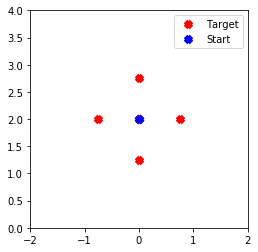

In [3]:
# create a set of targets to reach to
n_reaches = 4
distance = .75
center = [0, 2.0]
end_points = [[distance * np.cos(theta) + center[0],
               distance * np.sin(theta) + center[1]]
              for theta in np.linspace(0, 2*np.pi, n_reaches+1)][:-1]
targets = np.vstack([[center, ep] for ep in end_points])

plt.plot(center[0], center[1], 'bx', mew=5, label='Start')
for i, end_point in enumerate(end_points):
    plt.plot(end_point[0], end_point[1], 'x', mew=5, label='Target %d' % (i + 1))
plt.gca().set_aspect('equal')
plt.legend()

In [4]:
def build_baseline_model():
    with nengo.Network(label="Nonlinear adaptive control") as model:
    
        # Create node that specifies target
        def gen_target(t):
            # Advance to the next target in the list every 2 seconds
            return targets[int(t / 2) % len(targets)]
        target_node = nengo.Node(output=gen_target, size_out=2)

        # Create node that calculates the OSC signal
        model.osc_node = nengo.Node(
            output=lambda t,x: ctrlr.generate(
                q=x[:2], dq=x[2:4],target_pos=np.hstack([x[4:6], 0])),
            size_in=6, size_out=2)

        # Create node that runs the arm simulation and gets feedback
        def arm_func(t, x):
            u = x[:2]  # the OSC signal
            u += x[2:4] * 10  # add in the adaptive control signal
            arm_sim.send_forces(u)  # step the arm simulation forward
            # return arm joint angles, joint velocities, and hand (x,y)
            return np.hstack([arm_sim.q, arm_sim.dq, arm_sim.x]) 
        model.arm_node = nengo.Node(output=arm_func, size_in=4)

        # hook up the OSC controller and arm simulation
        nengo.Connection(model.osc_node, model.arm_node[:2])
        nengo.Connection(model.arm_node[:4], model.osc_node[:4])
        # send in current target to the controller
        nengo.Connection(target_node, model.osc_node[4:6])
    
        model.probe_target = nengo.Probe(target_node)  # track targets
        model.probe_hand = nengo.Probe(model.arm_node[4:6])  # track hand (x,y)
        
    return model
baseline_model = build_baseline_model()

Loading cython function from joint0[0,0,0]_Tx ...
Loading cython function from joint1[0,0,0]_Tx ...
Loading cython function from EE[0,0,0]_Tx ...


## Running the network in Nengo

We can now run the basic framework, where the operational space controller will drive the hand to the 4 targets around the circle.

In [5]:
# each reach is 2 seconds out + 2 seconds back in
runtime = n_reaches * 2 * 2 + 2

arm_sim.reset()
with nengo.Simulator(baseline_model, progress_bar=False) as sim:
    sim.run(runtime)
baseline_t = sim.trange()
baseline_data = sim.data

Loading cython function from EE[0,0,0]_J ...
Loading cython function from M ...
Loading cython function from g ...


The error is calculated as the difference between the hand (x,y) position and the target. Whenever the target changes, the error will jump up, and then quickly decrease as the hand approaches the target.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fddd85a2828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fddd8532b38>)

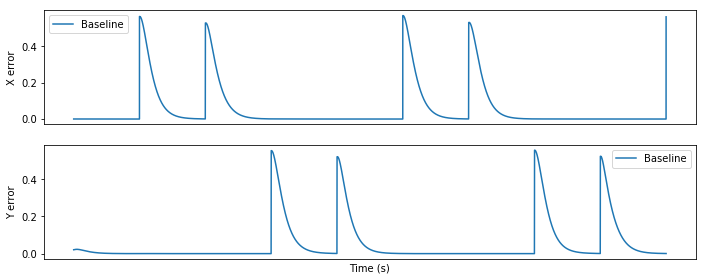

In [6]:
def calculate_error(model, data):
    return data[model.probe_hand] - data[model.probe_target]
baseline_error = calculate_error(baseline_model, baseline_data)

def plot_data(t_set, data_set, label_set):
    plt.figure(figsize=(10, 6))
    plt.title("Distance to target")
    
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_set[0], np.zeros_like(t_set[0]), 'k--')
    plt.xticks([])
    plt.ylabel('X error')
    
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(t_set[0], np.zeros_like(t_set[0]), 'k--')
    plt.xticks([])
    plt.ylabel('Y error')
    plt.xlabel("Time (s)")
    
    plt.tight_layout()
    
    for t, data, label in zip(t_set, data_set, label_set):
        ax1.plot(t, data[:, 0], label=label)
        ax2.plot(t, data[:, 1], label=label)
    
    ax1.legend(loc=1)
    ax2.legend(loc=1)
    
    return ax1, ax2

plot_data(
    [baseline_t],
    [baseline_error],
    ['Baseline'])

## Adding unexpected gravity

Now we add gravity along the y-axis to the 2-link arm model, which it is not expecting. As a result, the error will be much greater as it tries to reach to the various targets, relative to baseline performance.

In [7]:
def add_gravity(model):
    with model:
        # calculate and add in gravity along y axis
        gravity = np.array([0, -9.8, 0, 0, 0, 0])
        M0g = np.dot(robot_config._M_LINKS[0], gravity)
        M1g = np.dot(robot_config._M_LINKS[1], gravity)
        def gravity_func(t, q):
            g = np.dot(robot_config.J('link1', q=q).T, M0g)
            g += np.dot(robot_config.J('link2', q=q).T, M1g)
            return g
        gravity_node = nengo.Node(gravity_func, size_in=2, size_out=2)
        # connect perturbation to arm
        nengo.Connection(model.arm_node[:2], gravity_node)
        nengo.Connection(gravity_node, model.arm_node[:2])
        
    return model
gravity_model = add_gravity(build_baseline_model())

In [8]:
arm_sim.reset()
with nengo.Simulator(gravity_model, progress_bar=False) as sim:
    sim.run(runtime)
gravity_t = sim.trange()
gravity_data = sim.data

Loading cython function from link1[0,0,0]_J ...
Loading cython function from link2[0,0,0]_J ...


(<matplotlib.axes._subplots.AxesSubplot at 0x7fddd84ffac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fddd8208208>)

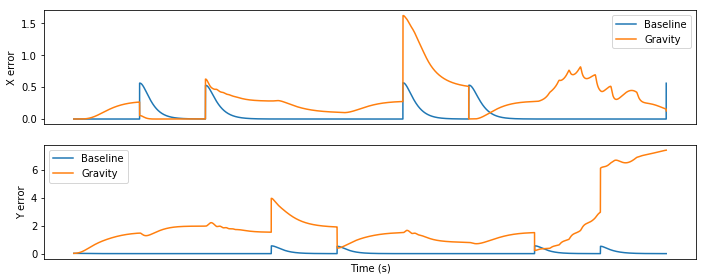

In [9]:
gravity_error = calculate_error(gravity_model, gravity_data)
plot_data(
    [baseline_t, gravity_t],
    [baseline_error, gravity_error],
    ['Baseline', 'Gravity'])

As expected, the error is much worse, especially along the Y axis (take note of the scale of the axes), because gravity is affecting the system and the operational space controller is not accounting for it.

## Adding nonlinear adaptive control

Now we add in an ensemble of neurons to perform context sensitive error integration, as presented in (DeWolf, Stewart, Slotine, and Eliasmith, 2015).

In [10]:
def add_adaptation(model, learning_rate=1e-5):
    with model:
        # create ensemble to adapt to unmodeled dynamics
        adapt = nengo.Ensemble(n_neurons=1000, dimensions=2, radius=np.sqrt(2))
        scale_node = nengo.Node(
            output=lambda t, x: robot_config.scaledown('q', x), size_in=2, size_out=2)
        nengo.Connection(model.arm_node[:2], scale_node) # to send target info to ensemble
        nengo.Connection(scale_node, adapt)
    
        # create the learning connection from the ensemble to the arm simulation
        learn_conn = nengo.Connection(adapt, model.arm_node[2:4],
                                      function=lambda x: np.zeros(2),
                                      learning_rule_type=nengo.PES(learning_rate),
                                      synapse=0.05)
        # connect up the osc signal as the training signal
        nengo.Connection(model.osc_node, learn_conn.learning_rule, transform=-1)
    return model
adapt_model = add_adaptation(add_gravity(build_baseline_model()))

In [11]:
arm_sim.reset()
with nengo.Simulator(adapt_model, progress_bar=False) as sim:
    sim.run(runtime)
adapt_t = sim.trange()
adapt_data = sim.data

(<matplotlib.axes._subplots.AxesSubplot at 0x7fddd81114e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fddd1a1b7b8>)

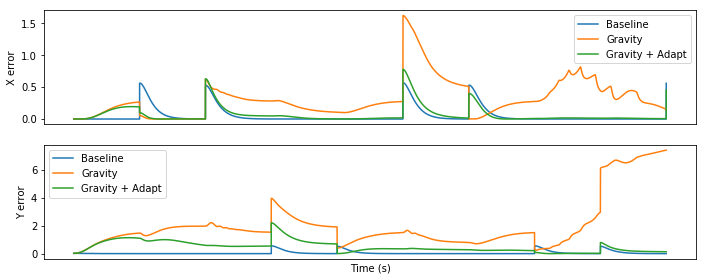

In [12]:
adapt_error = calculate_error(adapt_model, adapt_data)
plot_data(
    [baseline_t, gravity_t, adapt_t],
    [baseline_error, gravity_error, adapt_error],
    ['Baseline', 'Gravity', 'Gravity + Adapt'])

And we can see that even in only one pass through the target set the adaptive ensemble has already significantly reduced the error. To see further reductions, change the run time of the simulation to be longer so that the arm does multiple passes of the target set. 

## Running the network with Nengo Loihi

The Loihi has some implicit gains included in it so we use a learning rate of 1e-6 in Nengo Loihi, instead of 1e-5, to match the performance of the standard Nengo backend.

In [13]:
adapt_loihi_model = add_adaptation(add_gravity(build_baseline_model()), learning_rate=1e-6)
arm_sim.reset()
with nengo_loihi.Simulator(adapt_loihi_model) as sim:
    sim.run(runtime)
adapt_loihi_t = sim.trange()
adapt_loihi_data = sim.data

/home/tdewolf/Dropbox/code/nengo-loihi/nengo_loihi/loihi_api.py:450: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


(<matplotlib.axes._subplots.AxesSubplot at 0x7fddd1a031d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fddd3cc0fd0>)

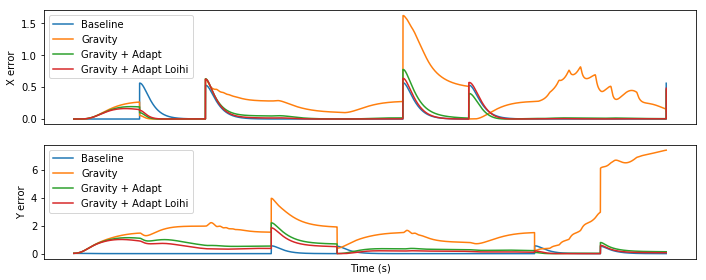

In [14]:
adapt_loihi_error = calculate_error(adapt_loihi_model, adapt_loihi_data)
plot_data(
    [baseline_t, gravity_t, adapt_t, adapt_loihi_t],
    [baseline_error, gravity_error, adapt_error, adapt_loihi_error],
    ['Baseline', 'Gravity', 'Gravity + Adapt', 'Gravity + Adapt Loihi'])